# Metric vs RLR for Dutch stations
This notebook checks the conversion from metric to post 2005 NAP. The conversion parameters are stored in figures (diagrams) at the PSMSL. These are hand coded into rlr2nap parameters. This notebook checks if these parameters correctly convert the rlr levels to NAP.  


In [1]:
import io
import zipfile

import numpy as np

import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# The datasets. TODO: put this in a configuration file
psmsl_urls = {
    'met_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
}
url_names = {
    'datum': '{dataset_name}/RLR_info/{id}.txt',
    'diagram': '{dataset_name}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'rlr_monthly': '{dataset_name}/data/{id}.rlrdata',
    'rlr_annual': '{dataset_name}/data/{id}.rlrdata',
    'met_monthly': '{dataset_name}/data/{id}.metdata',
    'doc': '{dataset_name}/docu/{id}.txt',
    'contact': '{dataset_name}/docu/{id}_auth.txt'
}

main_stations = [
    {
        'id': 20,
        'name': 'Vlissingen', 
        'rlr2nap': lambda x: x - (6976-46),
        'alpha': 118
    },
    {
        'id': 22,
        'name': 'Hoek van Holland', 
        'rlr2nap': lambda x:x - (6987 - 114),
        'alpha': 117
    },
    {
        'id': 23,
        'name': 'Den Helder', 
        'rlr2nap': lambda x: x - (6962 - 16),
        'alpha': 107
    },
    {
        'id': 24,
        'name': 'Delfzijl', 
        'rlr2nap': lambda x: x - (6953 - 130),
        'alpha': 117
    },
    {
        'id': 25,
        'name': 'Harlingen', 
        'rlr2nap': lambda x: x - (7024 - 110),
        'alpha': 108
    },
    {
        'id': 32,
        'name': 'IJmuiden', 
        'rlr2nap': lambda x: x - (7014 - 64),
        'alpha': 110
    }
]
stations_by_id = {station['id']: station for station in main_stations}

In [3]:
# Extract all datasets
dfs = []
for dataset_name, url in psmsl_urls.items():
    resp = requests.get(url)
    # we can read the zipfile
    stream = io.BytesIO(resp.content)
    zf = zipfile.ZipFile(stream)

    # this list contains a table of 
    # station ID, latitude, longitude, station name, coastline code, station code, and quality flag
    for id_ in [20, 22, 23, 24, 25,  32]:
        info = {"id": id_, "dataset_name": dataset_name}
        bytes = zf.read(url_names[dataset_name].format(**info))
        df = pd.read_csv(
            io.BytesIO(bytes), 
            sep=';', 
            names=('year', 'height', 'interpolated', 'flags')
        )
        df['station_id'] = id_
        df['dataset'] = dataset_name
        dfs.append(df)
merged = pd.concat(dfs)

In [4]:
# Compute all differences between relative and metric data
diffs = []
for station, df in merged.groupby('station_id'):
    pivotted = df.pivot(index='year', columns='dataset', values=['height'])
    pivotted['diff'] = np.diff(pivotted.height.values, axis=1)
    pivotted['station_id'] = station
    diffs.append(pivotted)
diffs = pd.concat(diffs)    

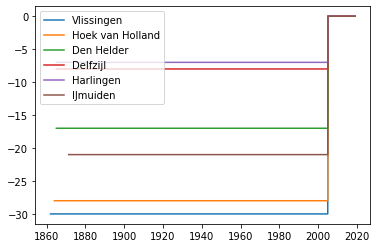

In [5]:
# All lines should end at 0, so that all values are relative to post 2005  NAP
# These differences should correspond to the NAP publicatie 2004/5
fig, ax = plt.subplots()
for station_id, group in diffs.reset_index().groupby('station_id'):
    station = stations_by_id[station_id]
    nap_diff = station['rlr2nap'](group['diff'])
    ax.plot(group.year, nap_diff, label=station['name'])
ax.legend();